## Gradient Class-Activation Maps (Grad-CAM)
In this notebook we will use the [Grad-CAM algorithm](https://arxiv.org/abs/1610.02391) to visualize which regions in an image dominate the decision for a specific class in a classification neural network. We visualize where the network is _looking_.

In [1]:
import torchvision.models
from torchvision.models import resnet50
from torchvision import transforms
from skimage.transform import resize
import torch
from skimage.io import imread
import stackview
import numpy as np
from functools import partial
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from utilities import visualize_image_list
from torchvision.models import ResNet50_Weights as W

## Loading the model
We use the [ResNet](https://arxiv.org/abs/1512.03385) architecture and more specifically [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html), a pretrained model for classifying images. 

In [2]:
resnet_model = resnet50(weights=W, progress=False)
model = resnet_model.eval()

C:\Users\rober\miniforge3\envs\genai-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


It was trained on [ImageNet](https://www.image-net.org/). For academic purposes, we can print out some class names available in ImageNet.

In [3]:
classes = W.DEFAULT.meta["categories"]
classes[:5]

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']

In [4]:
len(classes)

1000

Here we use a dictionay as lookup-table to get the index of a specific class name. We will later use this to determine weights for specific classes.

In [5]:
class_to_idx = {cls: idx for (idx, cls) in enumerate(classes)}
class_to_idx["flagpole"]

557

## Example image data for classification

In the following we will us a cropped image licensed [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) by HTW Dresden / Peter Sebb ([Source](https://de.wikipedia.org/wiki/Hochschule_f%C3%BCr_Technik_und_Wirtschaft_Dresden#/media/Datei:Hochschule_f%C3%BCr_Technik_und_Wirtschaft_(HTW)_Dresden_-_Zentralgeb%C3%A4ude,_Campus_Friedrich_List_Platz.jpg)).

StackViewNDArray([[[ 44,  65,  40],
                   [ 47,  67,  43],
                   [ 45,  64,  41],
                   ...,
                   [185, 182, 181],
                   [187, 185, 185],
                   [124, 123, 125]],

                  [[ 29,  49,  27],
                   [ 50,  70,  49],
                   [ 40,  58,  38],
                   ...,
                   [188, 184, 185],
                   [196, 194, 196],
                   [132, 132, 134]],

                  [[ 35,  54,  34],
                   [ 57,  76,  57],
                   [ 62,  79,  61],
                   ...,
                   [184, 180, 184],
                   [197, 195, 199],
                   [133, 132, 138]],

                  ...,

                  [[ 34,  48,  16],
                   [ 26,  39,   7],
                   [ 36,  50,  18],
                   ...,
                   [ 39,  48,  16],
                   [ 30,  39,   7],
                   [ 45,  55,  22]],

                  [[ 38,  51,  19],
                   [ 38,  51,  19],
                   [ 48,  62,  28],
                   ...,
                   [ 38,  47,  16],
                   [ 37,  47,  16],
                   [ 33,  42,  11]],

                  [[ 33,  46,  13],
                   [ 40,  53,  19],
                   [ 54,  67,  33],
                   ...,
                   [ 34,  43,  13],
                   [ 36,  46,  15],
                   [ 34,  43,  13]]], dtype=uint8)
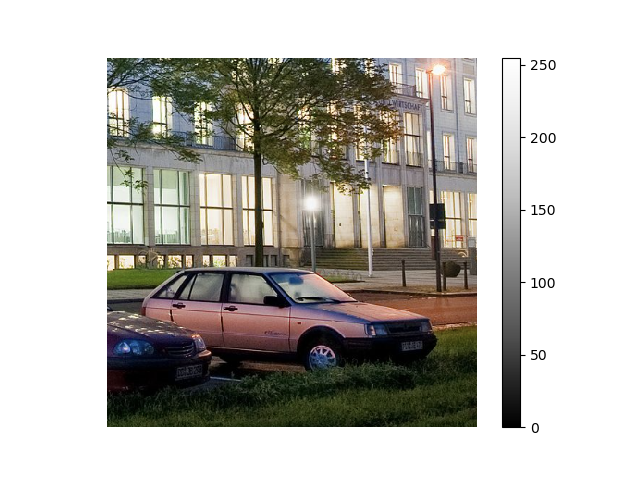
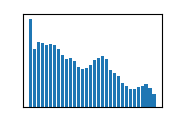

In [6]:
original_image = imread("data/htw-front-cc-by-sa.png")[...,:3]

stackview.insight(original_image)

Next, we convert this image to a Pytorch tensor, which is required to process it by the neural network.

In [7]:
input_tensor = transforms.ToTensor()(original_image).unsqueeze(0)
input_tensor.shape

torch.Size([1, 3, 400, 400])

## Storing feature images and gradients
In the following code, we register some callback function in the network to be able to access intermediate results of the algorithm such as feature images and gradients. This will slow down processing a bit and is not recommended in production.

In [8]:
layers = [model.layer1, model.layer2, model.layer3, model.layer4]

features = [None] * len(layers)
gradients = [None] * len(layers)

def save_feature_maps(i, module, inp, out):
    features[i] = out

def save_gradients(i, module, inp, out):
    gradients[i] = out[0]

for i, layer in enumerate(layers):
    layer.register_forward_hook(partial(save_feature_maps, i))
    layer.register_full_backward_hook(partial(save_gradients, i))

## Prediction step
To visualize what the network is doing, we need to execute it. After this step, the classification result is availale.

In [9]:
output = model(input_tensor)

output.shape

torch.Size([1, 1000])

The class index and class name of the classification is:

In [10]:
class_idx = output.argmax(axis=1).detach()
class_idx, classes[class_idx]

(tensor([436]), 'beach wagon')

## Inspecting the intermediate results
As we stored intermediate results (feature images), we can now visualize them.

In [11]:
features[0].shape

torch.Size([1, 256, 100, 100])

### Layer 1 (256, 100, 100)

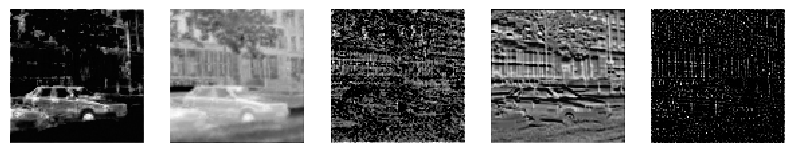

### Layer 2 (512, 50, 50)

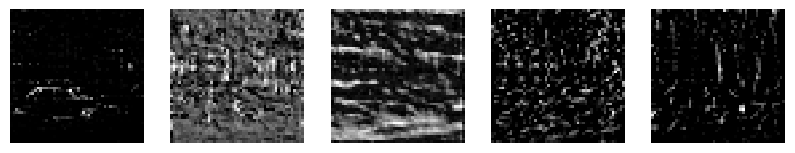

### Layer 3 (1024, 25, 25)

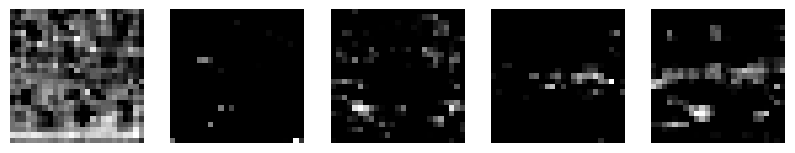

### Layer 4 (2048, 13, 13)

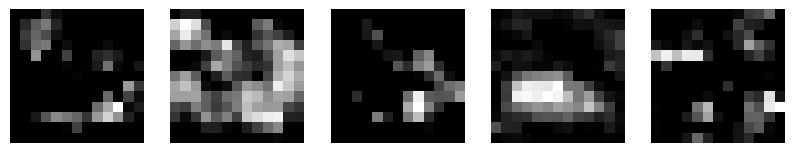

In [12]:
for i, layer in enumerate(layers):

    layer_features = features[i][0].detach().numpy()
    
    display(Markdown(f"### Layer {i+1} {layer_features.shape}"))

    num_figs = 5
    f, a = plt.subplots(1,num_figs, figsize=(10,2))
    for f in range(num_figs):
        stackview.imshow(layer_features[f], plot=a[f])
    plt.show()
    
    #display(stackview.insight())

The deeper the layer (higher layer number), the less interpretable the images are.

## Determining gradients
To determine the gradients, we use a single back-propagation step using the class we just determined. This is like we would do during training to improve classification quality for this one specific class given this one specific input image.

In [13]:
model.zero_grad()

In [14]:
one_hot = torch.zeros_like(output)
one_hot[0][class_idx[0]] = 1
output.backward(gradient=one_hot)

We can summarize these gradients to one weight-adaption number for each feature image in the last convolutional layer. The higher this number, the more relevant is the specific feature image for making the classification for this one specific class.

In [15]:
weight_adaption = torch.mean(gradients[-1], dim=(2, 3))[0]
weight_adaption.shape

torch.Size([2048])

In [16]:
weight_adaption[:3]

tensor([-3.8505e-05, -2.3461e-04, -6.0150e-05])

In [17]:
weight_adaption.max()

tensor(0.0012)

## Summarizing feature images
For visualization purposes we just show the first feature images of the last/deepest convolutional layer again. These images will be multiplied with the weight-adaptions explained above.

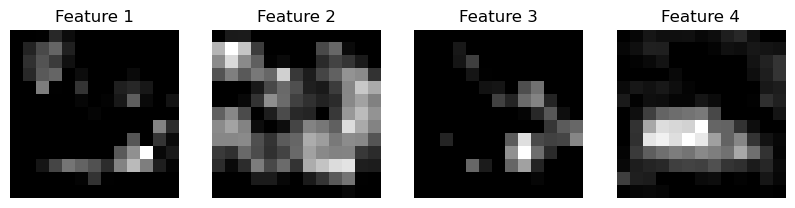

In [18]:
num_features = 4
images = []
image_names = []

for i, f in enumerate(features[-1][0][:num_features]):
    images.append(f.detach().cpu().numpy())
    image_names.append(f"Feature {i+1}")
    
visualize_image_list(images, image_names)

In [19]:
# Create CAM
cam = torch.zeros(features[-1].shape[2:], dtype=torch.float32)

# Multiply weights with feature maps and sum
for i, w in enumerate(weight_adaption):
    cam += w * features[-1][0][i]

After multiplication, these images will be summarized into a single image that shows us where in the specific image the network is _looking_ when checking the speicified class. This is a class-activation map.

StackViewNDArray([[0.        , 0.        , 0.        , 0.        ,
                   0.00367999, 0.00410484, 0.00141252, 0.        ,
                   0.        , 0.00414139, 0.00367799, 0.00071303,
                   0.        ],
                  [0.        , 0.        , 0.        , 0.00899425,
                   0.01280738, 0.01529889, 0.01050086, 0.00322412,
                   0.00318271, 0.00316701, 0.00285351, 0.00143898,
                   0.        ],
                  [0.        , 0.        , 0.00665781, 0.02179979,
                   0.03564567, 0.03271617, 0.02077457, 0.00912553,
                   0.01072758, 0.00479039, 0.00433156, 0.00531929,
                   0.0082409 ],
                  [0.00201411, 0.00909411, 0.0169385 , 0.02301124,
                   0.03362626, 0.03091616, 0.0238859 , 0.01016567,
                   0.00991163, 0.00703905, 0.00890792, 0.00743718,
                   0.00831305],
                  [0.00918072, 0.01130094, 0.01255787, 0.01874495,
                   0.02302746, 0.02050206, 0.02166294, 0.01086617,
                   0.00650213, 0.0061704 , 0.01196426, 0.01329138,
                   0.01344251],
                  [0.01240652, 0.01578724, 0.01916824, 0.02471689,
                   0.02584605, 0.0234451 , 0.01872788, 0.0092352 ,
                   0.00823218, 0.00452829, 0.00687641, 0.00214093,
                   0.00463269],
                  [0.01599856, 0.03501049, 0.06131722, 0.07109255,
                   0.07465433, 0.07452544, 0.07041776, 0.0439342 ,
                   0.01727879, 0.00975083, 0.01327672, 0.00276198,
                   0.00201019],
                  [0.02461884, 0.0651761 , 0.12575512, 0.15282175,
                   0.12728679, 0.12376218, 0.1167626 , 0.11563043,
                   0.0881178 , 0.05650756, 0.02481676, 0.01180768,
                   0.0040583 ],
                  [0.03317939, 0.06646536, 0.13947989, 0.16129449,
                   0.12088632, 0.13169834, 0.11606354, 0.12967116,
                   0.11338447, 0.09101339, 0.05432599, 0.03169559,
                   0.02326291],
                  [0.035825  , 0.0476924 , 0.07803867, 0.10419504,
                   0.0834337 , 0.09494817, 0.09030281, 0.12444094,
                   0.12347736, 0.10823441, 0.08183137, 0.04467252,
                   0.02906882],
                  [0.03606438, 0.04068006, 0.04666305, 0.05812545,
                   0.06947589, 0.08348025, 0.05787768, 0.09193928,
                   0.09570534, 0.09630498, 0.07139783, 0.04628622,
                   0.02123731],
                  [0.03533571, 0.04279369, 0.03873261, 0.03486139,
                   0.02892865, 0.02271403, 0.0201452 , 0.02362178,
                   0.02583394, 0.0257995 , 0.02722543, 0.01866124,
                   0.01041161],
                  [0.00193345, 0.01390701, 0.01751637, 0.01414947,
                   0.00790935, 0.00665481, 0.00584138, 0.00667341,
                   0.00864425, 0.004967  , 0.00560331, 0.00455316,
                   0.00187564]], dtype=float32)
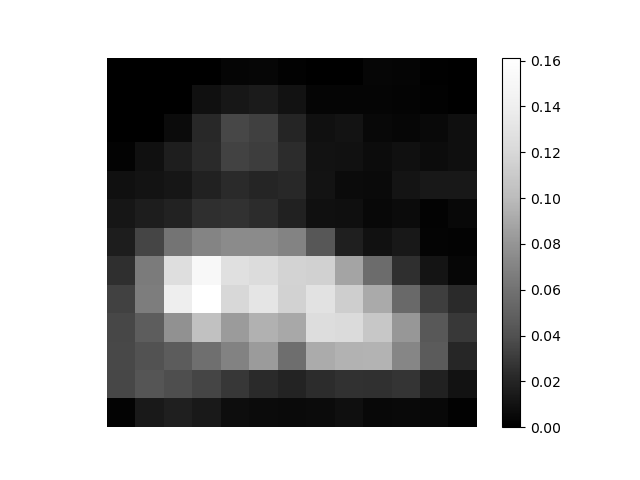
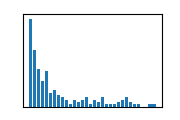

In [20]:
projected_cam = torch.maximum(cam, torch.tensor(0)).detach().cpu().numpy()

stackview.insight(projected_cam)

## Overlay
To visualize this map on top of the original image, we create an upsampled, interpolated image of it.

StackViewNDArray([[0.        , 0.        , 0.        , ..., 0.00044564,
                   0.00048022, 0.00051481],
                  [0.        , 0.        , 0.        , ..., 0.00043576,
                   0.00046958, 0.0005034 ],
                  [0.        , 0.        , 0.        , ..., 0.00042588,
                   0.00045893, 0.00049199],
                  ...,
                  [0.02079814, 0.02047045, 0.02014276, ..., 0.00754837,
                   0.00771122, 0.00787407],
                  [0.02181272, 0.0214898 , 0.02116688, ..., 0.00790162,
                   0.00807036, 0.00823909],
                  [0.0228273 , 0.02250915, 0.022191  , ..., 0.00825487,
                   0.00842949, 0.00860412]], dtype=float32)
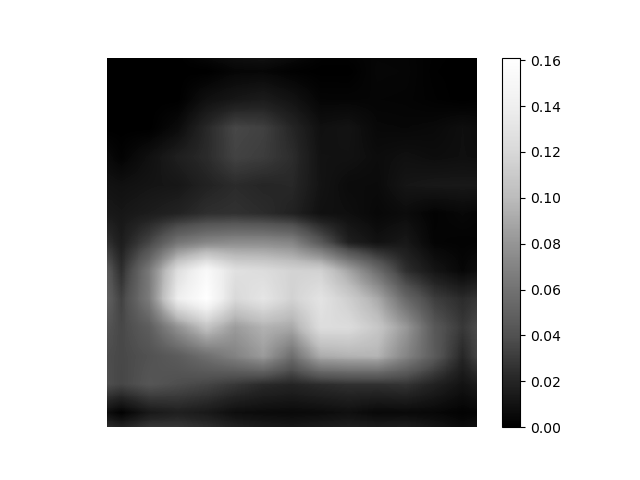
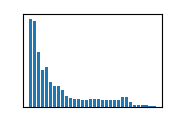

In [21]:
upsampled_cam = resize(projected_cam, (original_image.shape[0], original_image.shape[1]))

stackview.insight(upsampled_cam)

These two images can be visualized on top of each other.

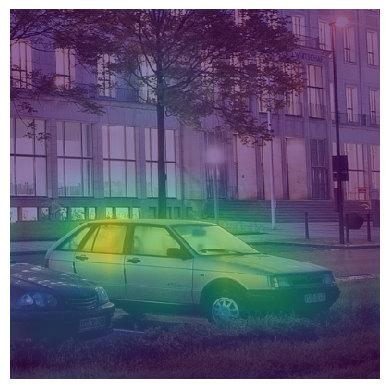

In [22]:
stackview.imshow(original_image, continue_drawing=True)
stackview.imshow(upsampled_cam, colormap='viridis', alpha=0.6)

## Class activation maps for different classes
We can compute this visualization also for other classes. To simplify this, we write a Python helper function, which does the same as above.

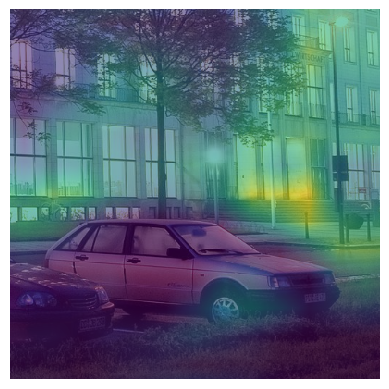

In [23]:
def show_cam_for_class(class_name):
    class_idx = [class_to_idx[class_name]]
    output = model(input_tensor)
    
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0][class_idx[0]] = 1
    output.backward(gradient=one_hot)
    
    feature_weights = torch.mean(gradients[-1], dim=(2, 3))[0]
    
    # Create CAM
    cam = torch.zeros(features[-1].shape[2:], dtype=torch.float32)
    
    # Multiply weights with feature maps and sum
    for i, w in enumerate(feature_weights):
        cam += w * features[-1][0][i]
    
    projected_cam = torch.maximum(cam, torch.tensor(0)).detach().cpu().numpy()
    
    upsampled_cam = resize(projected_cam, (original_image.shape[0], original_image.shape[1]))
    
    stackview.imshow(original_image, continue_drawing=True)
    stackview.imshow(upsampled_cam, colormap='viridis', alpha=0.6)

show_cam_for_class("palace")

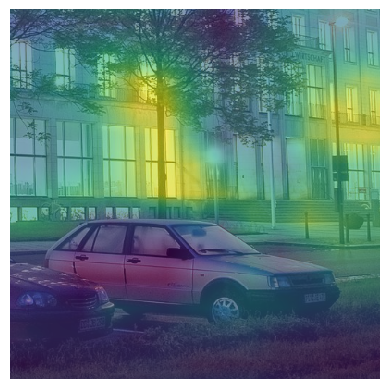

In [24]:
show_cam_for_class("flagpole")

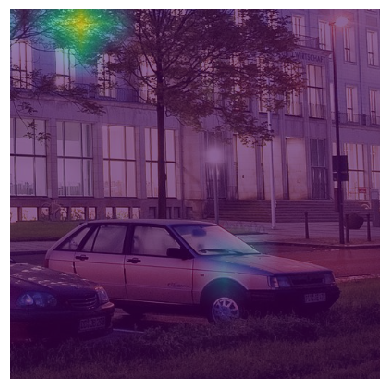

In [25]:
show_cam_for_class("great white shark")

## Exercise
What needs to be changed above to make sure the classification returns "car"? 

## Exercise 
Write a Python function that takes an image filename as parameter and returns the class name as string and a corresponding CAM image. Call this function in a loop which iterates over all images in the folder 'data'.